In [1]:
import numpy as np
import pandas as pd
from tsfresh import extract_features
import util

data_path = "../data/"

In [2]:
all_assets_df = pd.read_csv(data_path+"ALL_Assets.csv",encoding = "utf-8-sig")
all_assets_df.head(3)

,id,rank,symbol,name,supply,maxSupply,marketCapUsd,volumeUsd24Hr,priceUsd,changePercent24Hr,vwap24Hr,explorer
0,bitcoin,1,BTC,Bitcoin,1.965837e+07,21000000.0,1.303884e+12,1.212996e+10,66327.148890,-1.939361,66267.346653,https://blockchain.info/
1,ethereum,2,ETH,Ethereum,1.200774e+08,NaN,4.231424e+11,7.009960e+09,3523.912627,-0.801426,3516.792519,https://etherscan.io/
2,tether,3,USDT,Tether,1.036182e+11,NaN,1.037045e+11,2.763992e+10,1.000833,-0.069075,1.001213,https://www.omniexplorer.info/asset/31


In [3]:
all_assets_price_df = pd.read_csv(data_path+"ALL_Assets_price_raw.csv",encoding = "utf-8-sig", index_col=0)
all_assets_price_df.tail(3)
# all_assets_price_df

,bitcoin,ethereum,tether,binance-coin,solana,usd-coin,xrp,dogecoin,cardano,avalanche,...,sapphire,savedroid,scorecoin,seal-network,securecoin,seele,seer,segwit2x,selfsell,senderon
date,,,,,,,,,,,,,,,,,,,,,
2024-03-19 00:00:00+00:00,64392.559734,3322.053274,1.000274,524.195936,181.105944,1.000652,0.601550,0.132726,0.618317,57.931063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-20 00:00:00+00:00,63887.775990,3289.108261,1.000647,527.806801,175.271056,1.001020,0.594147,0.134910,0.607420,53.567902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-21 00:00:00+00:00,66707.021708,3514.274264,1.000995,555.909109,186.756380,1.001061,0.622298,0.152505,0.634803,54.991942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
from functools import partial

# Calculate daily returns
def calculate_daily_returns(price_df):
    return_df = price_df.pct_change(fill_method=None)
    return return_df

def calculate_daily_log_returns(price_df):
    # Calculate daily log returns
    return_df = np.log(price_df / price_df.shift(1))
    return return_df

def get_valid_assets(return_df, i, w):
    start = max(1, i-w)
    valid_assets = return_df.iloc[start:i].dropna(axis=1)
    return valid_assets


# Select top n assets
def select_top_n(df, n, w, i, winners=True):
    if winners:
        selected = df.mean().nlargest(min(n, df.shape[1])).index.tolist()
    else:
        selected = df.mean().nsmallest(min(n, df.shape[1])).index.tolist()
    return selected


# Partially apply the select_top_n function to create new functions
select_top_n_winners = partial(select_top_n, winners=True)
select_top_n_losers = partial(select_top_n, winners=False)

# Select assets based on time-series features
# def select_assets_based_on_features(features, returns, n):
#     # Calculate the correlation of features with returns
#     correlations = features.corrwith(returns)
#     # Select the n assets with the highest correlation
#     selected = correlations.nlargest(n).index
#     return selected

# def select_based_on_features(df, n, w, i):
#     start = max(0, i-w)
#     past_returns = df.iloc[start:i]
#     # Convert to DataFrame if necessary
#     if isinstance(past_returns, pd.Series):
#         past_returns = past_returns.to_frame()
#     # Transform the DataFrame into the required format
#     past_returns = past_returns.stack().reset_index()
#     past_returns.columns = ['date', 'asset', 'return']
#     # Specify a chunk size when extracting features
#     features = extract_features(past_returns, column_id='asset', column_sort='date', n_jobs=0, chunksize=10)
#     # Calculate the mean return for each asset
#     returns = past_returns.groupby('asset')['return'].mean()
#     selected = select_assets_based_on_features(features, returns, n)
#     return selected

    
def equal_weighting(df, n, w, i):
    return df.columns  # Select all assets

# Construct portfolio
def construct(return_df, w, strategy_func, n):
    l = return_df.shape[0]
    portfolio_returns = []
    for i in range(l):
        valid_assets = get_valid_assets(return_df, i, w)
        selected_assets = strategy_func(valid_assets, n, w, i)
        # Filter out extreme values
        daily_returns = return_df[selected_assets].iloc[i]
        filtered_returns = daily_returns[(daily_returns > -1e1) & (daily_returns < 1e1)]
        daily_return = filtered_returns.mean()
        portfolio_returns.append(daily_return)
    return portfolio_returns

In [5]:
# Load data
price_df = pd.read_csv(data_path+"ALL_Assets_price_raw.csv", encoding="utf-8-sig", index_col=0)

# Calculate daily returns
return_df = calculate_daily_log_returns(price_df)

# Construct the portfolio
portfolio_returns = construct(return_df, 10, equal_weighting, 10)

# Create a DataFrame for the portfolio
portfolio_df = pd.DataFrame(portfolio_returns, columns=['log_return'], index=return_df.index)
portfolio_df
# portfolio_df.to_csv("equal_weighting_return.csv",encoding = "utf-8-sig", index=1)
# portfolio_df = pd.read_csv(data_path+"equal_weighting_return.csv",encoding = "utf-8-sig", index_col=0)
# portfolio_df

,log_return
date,
2014-01-03 00:00:00+00:00,NaN
2014-01-05 00:00:00+00:00,0.090711
2014-01-07 00:00:00+00:00,0.018081
2014-01-08 00:00:00+00:00,-0.081816
2014-01-09 00:00:00+00:00,0.010104
...,...
2024-03-17 00:00:00+00:00,-0.034767
2024-03-18 00:00:00+00:00,0.000749
2024-03-19 00:00:00+00:00,-0.073647


In [6]:
portfolio_df.min()

log_return   -0.242408
dtype: float64

In [7]:
portfolio_returns2 = construct(return_df, 1, select_top_n_winners, 300)

# Create a DataFrame for the portfolio
portfolio_df2 = pd.DataFrame(portfolio_returns2, columns=['log_return'], index=return_df.index)
portfolio_df2

,log_return
date,
2014-01-03 00:00:00+00:00,NaN
2014-01-05 00:00:00+00:00,0.090711
2014-01-07 00:00:00+00:00,0.018081
2014-01-08 00:00:00+00:00,-0.081816
2014-01-09 00:00:00+00:00,0.010104
...,...
2024-03-17 00:00:00+00:00,-0.039909
2024-03-18 00:00:00+00:00,0.009238
2024-03-19 00:00:00+00:00,-0.070680


In [8]:
def calculate_periodic_returns(daily_returns, w):
    # Create a new series to hold the periodic returns
    periodic_returns = pd.Series(index=daily_returns.index)
    
    # Calculate the return for each period
    for t in range(0, len(daily_returns), w):
        # Calculate the product of the daily returns for this period
        periodic_return = (daily_returns.iloc[t:t+w] + 1).prod(axis=0) - 1
        # periodic_return = (daily_returns.iloc[t:t+w]).sum(axis=0)
        # Store the periodic return
        periodic_returns.iloc[t] = periodic_return
    
    # Remove the NaN values that were created for the days we didn't trade
    periodic_returns = periodic_returns.dropna()
    
    # Convert the series to a dataframe and add a column name
    periodic_returns = pd.DataFrame(periodic_returns, columns=['return'])
    
    return periodic_returns

def calculate_periodic_log_returns(daily_log_returns, w):
    # This function calculates the log returns for each period (e.g., every w days).
    # For each period, it sums up the daily log returns within that period.
    periodic_returns = pd.Series(index=daily_log_returns.index)
    
    for t in range(0, len(daily_log_returns), w):
        # Calculate the sum of daily log returns for this period
        periodic_return = daily_log_returns.iloc[t:t+w].sum(axis=0)
        # Store the periodic return
        periodic_returns.iloc[t] = periodic_return
    
    # Remove the NaN values that were created for the days we didn't trade
    periodic_returns = periodic_returns.dropna()
    
    # Convert the series to a dataframe and add a column name
    periodic_returns = pd.DataFrame(periodic_returns, columns=['log_return'])
    
    return periodic_returns

In [9]:
portfolio_df2_d7 = calculate_periodic_log_returns(portfolio_df2, 7)
portfolio_df2_d7
portfolio_df_d7 = calculate_periodic_log_returns(portfolio_df, 7)
portfolio_df_d7

,log_return
date,
2014-01-03 00:00:00+00:00,0.096612
2014-01-13 00:00:00+00:00,-0.042238
2014-01-22 00:00:00+00:00,-0.035080
2014-02-01 00:00:00+00:00,-0.268392
2014-02-13 00:00:00+00:00,-0.386295
...,...
2024-02-21 00:00:00+00:00,0.049849
2024-02-28 00:00:00+00:00,0.085553
2024-03-06 00:00:00+00:00,0.120111


In [10]:
# def adjust_large_returns(df):
#     # Define a function to adjust large returns
#     def adjust_func(x):
#         while x > 1:
#             x -= 1
#         return x
#     # Apply the function to the 'return' column
#     df['return'] = df['return'].apply(adjust_func)    
#     return df


def calculate_cumulative_return(df):
    # Add 1 to all of the daily returns
    # df = adjust_large_returns(df)
    df_plus_one = df['return'] + 1
    # Calculate the cumulative product of these daily returns
    cumulative_return = df_plus_one.cumprod()
    
    return cumulative_return

def calculate_cumulative_log_return(df):
    # This function calculates the cumulative sum of log returns.
    # This is done by cumulatively summing up the daily log returns.
    cumulative_log_return = df['log_return'].cumsum()
    
    return cumulative_log_return

In [11]:
calculate_cumulative_log_return(portfolio_df2_d7)
calculate_cumulative_log_return(portfolio_df_d7)

date
2014-01-03 00:00:00+00:00    0.096612
2014-01-13 00:00:00+00:00    0.054375
2014-01-22 00:00:00+00:00    0.019294
2014-02-01 00:00:00+00:00   -0.249098
2014-02-13 00:00:00+00:00   -0.635392
                               ...   
2024-02-21 00:00:00+00:00   -3.981859
2024-02-28 00:00:00+00:00   -3.896306
2024-03-06 00:00:00+00:00   -3.776196
2024-03-13 00:00:00+00:00   -3.937894
2024-03-20 00:00:00+00:00   -3.883237
Name: log_return, Length: 524, dtype: float64

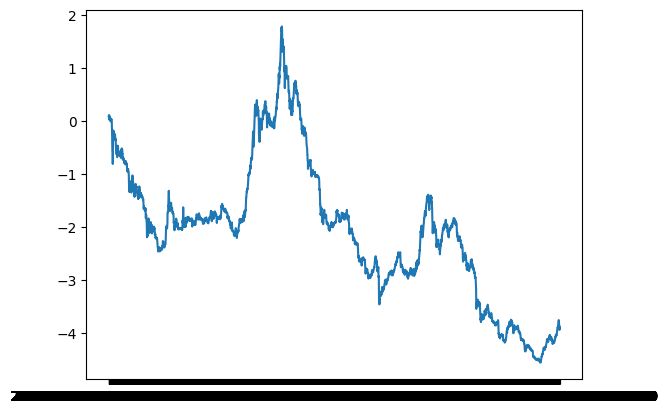

In [12]:
import matplotlib.pyplot as plt
plt.plot(calculate_cumulative_log_return(portfolio_df))

# plt.plot(portfolio_df)

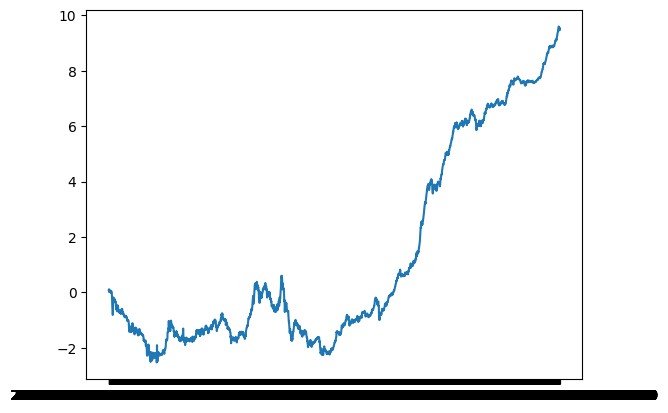

In [13]:
plt.plot(calculate_cumulative_log_return(portfolio_df2))

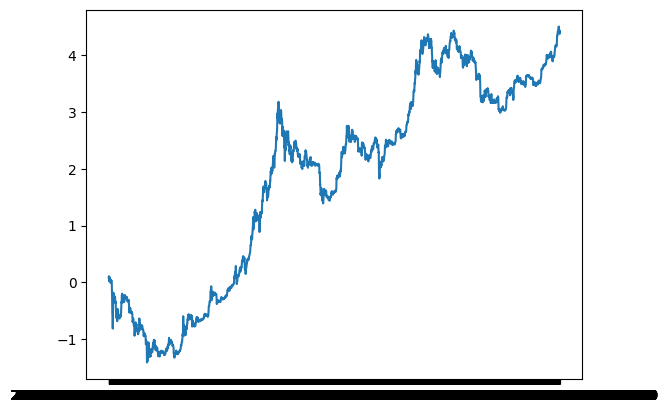

In [14]:
bitcoin_price_df = pd.DataFrame()
bitcoin_price_df['log_return'] = price_df["bitcoin"]
bitcoin_return_df = calculate_daily_log_returns(bitcoin_price_df)
plt.plot(calculate_cumulative_log_return(bitcoin_return_df))

In [15]:
n_assets = 300
look_back_window = 1
portfolio_returns2 = construct(return_df, look_back_window, select_top_n_winners, n_assets)

# Create a DataFrame for the portfolio
portfolio_df2 = pd.DataFrame(portfolio_returns2, columns=['log_return'], index=return_df.index)

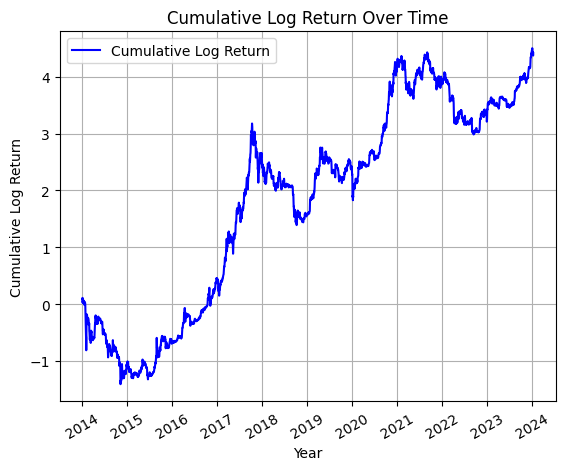

In [16]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()
cum_portfolio_df2 = calculate_cumulative_log_return(bitcoin_return_df)
# Plot the cumulative log return with a blue line
ax.plot(cum_portfolio_df2.index, cum_portfolio_df2, color='blue', linestyle='-')

# Set the title and labels
ax.set_title('Cumulative Log Return Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Log Return')

# Get the years from the index
years = [date.year for date in pd.to_datetime(cum_portfolio_df2.index)]

# Set the x-ticks to display years
ax.set_xticks(portfolio_df2.index[::365])  # Assuming 365 days in a year
ax.set_xticklabels(years[::365], rotation=30)  # Rotate labels by 30 degrees

# Enable the grid
ax.grid(True)

# Add a legend
ax.legend(['Cumulative Log Return'])

# Show the plot
plt.show()

In [17]:
import util
util.calculate_daily_risk_free_log_return()

7.93619301238376e-05

In [18]:
util.calculate_sharpe_ratio(portfolio_df2['log_return'])

0.05951313512520698

In [19]:
util.calculate_sharpe_ratio(portfolio_df['log_return'])

-0.03124626863976691

### Draw plots

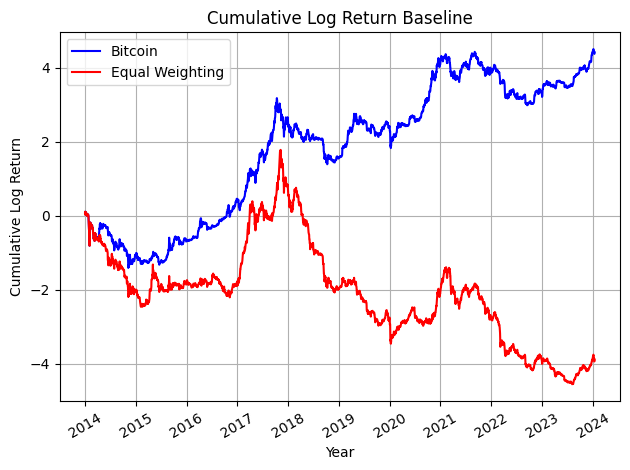

In [26]:
# baseline
# Create a DataFrame for the portfolio
n_assets = 300
look_back_window = 1
portfolio_df = pd.DataFrame(portfolio_returns, columns=['log_return'], index=return_df.index)

# Calculate the cumulative log return for both Bitcoin and the portfolio
cum_bitcoin_df = calculate_cumulative_log_return(bitcoin_return_df)
cum_portfolio_df = calculate_cumulative_log_return(portfolio_df)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the cumulative log return of Bitcoin with a blue line
ax.plot(cum_bitcoin_df.index, cum_bitcoin_df, color='blue', linestyle='-')

# Plot the cumulative log return of the portfolio with a red line
ax.plot(cum_portfolio_df.index, cum_portfolio_df, color='red', linestyle='-')

# Set the title and labels
ax.set_title('Cumulative Log Return Baseline')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Log Return')

# Get the years from the index
years = [date.year for date in pd.to_datetime(cum_portfolio_df.index)]

# Set the x-ticks to display years
ax.set_xticks(portfolio_df.index[::365])  # Assuming 365 days in a year
ax.set_xticklabels(years[::365], rotation=30)  # Rotate labels by 30 degrees

# Enable the grid
ax.grid(True)

# Add a legend
ax.legend(['Bitcoin', 'Equal Weighting'])
plt.tight_layout()
# Save the figure
# fig.savefig('cumulative_log_return_baseline.png')

# Show the plot
plt.show()

In [27]:
# save data
def extract_features(df):
    # save the previous 365 return as 365 features
    # Make sure your 'date' is the index of df
    df.index = pd.to_datetime(df.index)

    # Create new features
    new_features = []
    for w in range(1, 366):
        feature_df = pd.DataFrame()
        feature_df[f'sum_return_{w}d'] = df['log_return'].rolling(window=w).sum()
        feature_df[f'mean_return_{w}d'] = df['log_return'].rolling(window=w).mean()
        feature_df[f'min_return_{w}d'] = df['log_return'].rolling(window=w).min()
        feature_df[f'max_return_{w}d'] = df['log_return'].rolling(window=w).max()
        feature_df[f'value_{w}d_ago'] = df['log_return'].shift(w)  # log return value from w days ago
        new_features.append(feature_df)

    # Concatenate all new features
    df = pd.concat([df] + new_features, axis=1)

    # Handle missing values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    return df

In [29]:
equal_weight_w_feature = pd.DataFrame()
equal_weight_w_feature = extract_features(portfolio_df)
# equal_weight_w_feature.to_csv(data_path+"equal_weighting_w_feature.csv",encoding = "utf-8-sig", index=1)
equal_weight_w_feature

bitcoin_w_feature = pd.DataFrame()
bitcoin_w_feature = extract_features(bitcoin_return_df)
# bitcoin_w_feature.to_csv(data_path+"bitcoin_return_w_feature.csv",encoding = "utf-8-sig", index=1)
bitcoin_w_feature

,log_return,sum_return_1d,mean_return_1d,min_return_1d,max_return_1d,value_1d_ago,sum_return_2d,mean_return_2d,min_return_2d,max_return_2d,...,sum_return_364d,mean_return_364d,min_return_364d,max_return_364d,value_364d_ago,sum_return_365d,mean_return_365d,min_return_365d,max_return_365d,value_365d_ago
date,,,,,,,,,,,,,,,,,,,,,
2015-03-10 00:00:00+00:00,0.039555,0.039555,0.039555,0.039555,0.039555,0.025801,0.065356,0.032678,0.025801,0.039555,...,-1.119888,-0.003077,-0.233145,0.290826,0.018081,-1.101807,-0.003019,-0.233145,0.290826,0.090711
2015-03-11 00:00:00+00:00,-0.000167,-0.000167,-0.000167,-0.000167,-0.000167,0.039555,0.039388,0.019694,-0.000167,0.039555,...,-1.038238,-0.002852,-0.233145,0.290826,-0.081816,-1.120054,-0.003069,-0.233145,0.290826,0.018081
2015-03-12 00:00:00+00:00,0.003183,0.003183,0.003183,0.003183,0.003183,-0.000167,0.003016,0.001508,-0.000167,0.003183,...,-1.045159,-0.002871,-0.233145,0.290826,0.010104,-1.035055,-0.002836,-0.233145,0.290826,-0.081816
2015-03-13 00:00:00+00:00,-0.012090,-0.012090,-0.012090,-0.012090,-0.012090,0.003183,-0.008907,-0.004453,-0.012090,0.003183,...,-1.053439,-0.002894,-0.233145,0.290826,-0.003810,-1.057249,-0.002897,-0.233145,0.290826,0.010104
2015-03-14 00:00:00+00:00,-0.027121,-0.027121,-0.027121,-0.027121,-0.027121,-0.012090,-0.039211,-0.019605,-0.027121,-0.012090,...,-1.143903,-0.003143,-0.233145,0.290826,0.063343,-1.080560,-0.002960,-0.233145,0.290826,-0.003810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-17 00:00:00+00:00,-0.017802,-0.017802,-0.017802,-0.017802,-0.017802,-0.005209,-0.023011,-0.011506,-0.017802,-0.005209,...,0.890068,0.002445,-0.068636,0.098208,0.003789,0.893858,0.002449,-0.068636,0.098208,0.040392
2024-03-18 00:00:00+00:00,0.010801,0.010801,0.010801,0.010801,0.010801,-0.017802,-0.007001,-0.003501,-0.017802,0.010801,...,0.886687,0.002436,-0.068636,0.098208,0.014182,0.900869,0.002468,-0.068636,0.098208,0.003789
2024-03-19 00:00:00+00:00,-0.051620,-0.051620,-0.051620,-0.051620,-0.051620,0.010801,-0.040819,-0.020409,-0.051620,0.010801,...,0.832329,0.002287,-0.068636,0.098208,0.002739,0.835068,0.002288,-0.068636,0.098208,0.014182


In [32]:
# Define your parameters
look_back_window = [1, 7, 30, 365]
n_assets  = [100,200,300,500]

# Create arrays to store the portfolio DataFrames
portfolio_dfs_winners = []
portfolio_dfs_losers = []

for window in look_back_window:
    for assets in n_assets:
        # Construct the portfolio for winners and losers
        portfolio_returns_winners = construct(return_df, window, select_top_n_winners, assets)
        portfolio_returns_losers = construct(return_df, window, select_top_n_losers, assets)

        # Create DataFrames for the portfolios
        portfolio_df_winners = pd.DataFrame(portfolio_returns_winners, columns=['log_return'], index=return_df.index)
        portfolio_df_losers = pd.DataFrame(portfolio_returns_losers, columns=['log_return'], index=return_df.index)

        # Append the DataFrames to the arrays
        portfolio_dfs_winners.append(portfolio_df_winners)
        portfolio_dfs_losers.append(portfolio_df_losers)


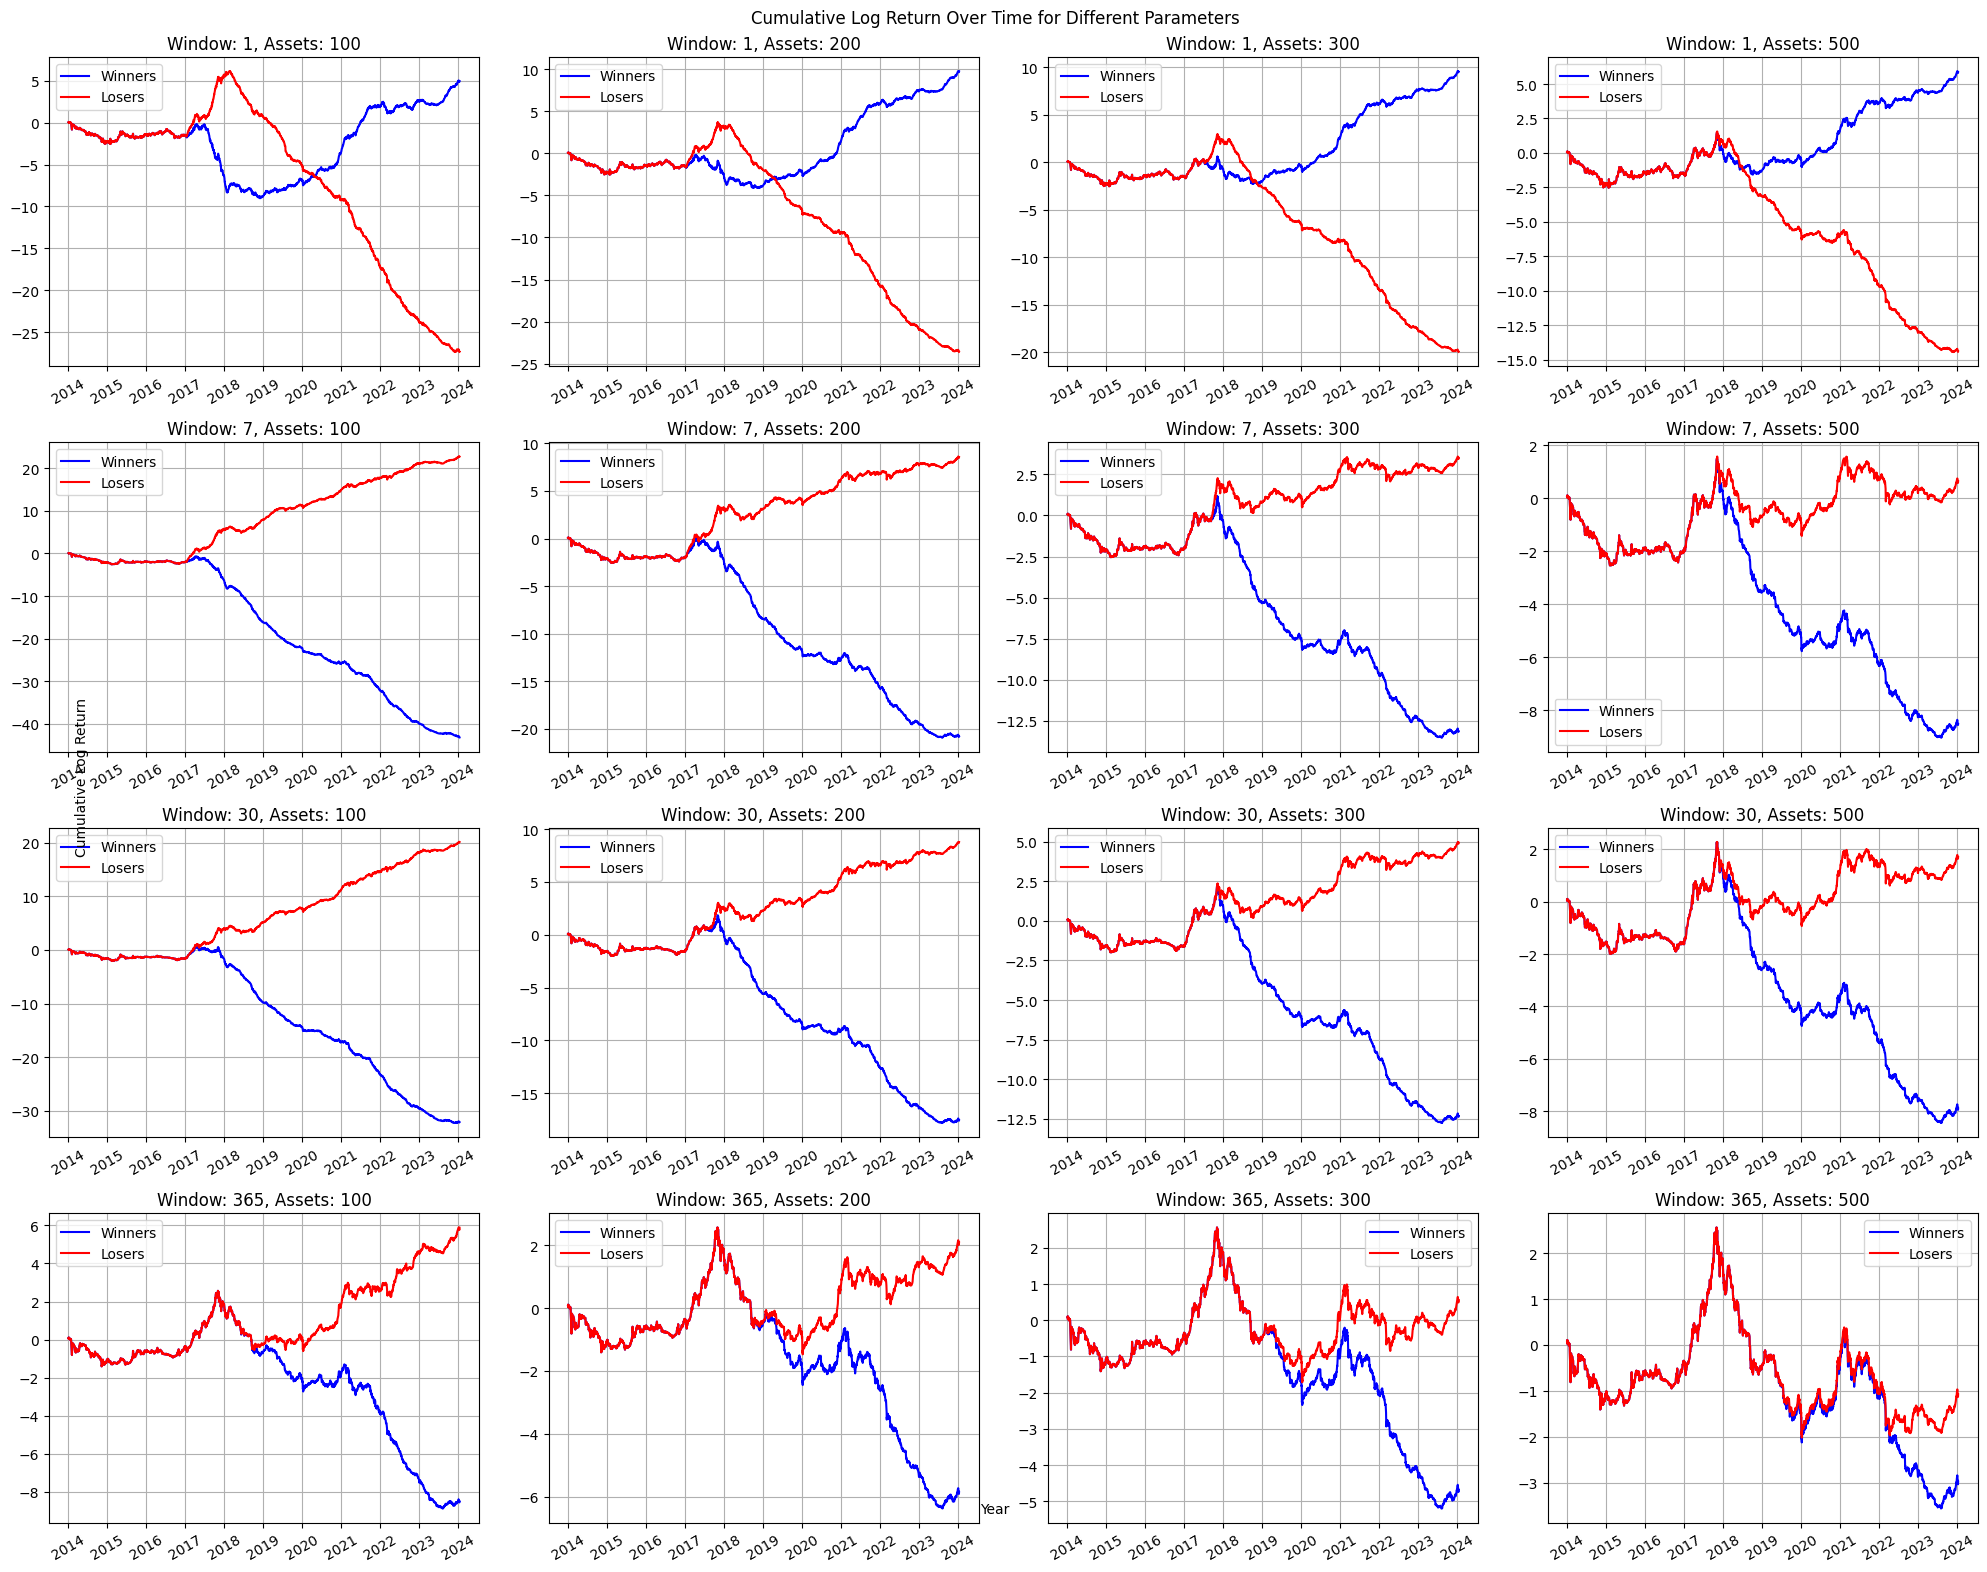

In [34]:
fig, axs = plt.subplots(4, 4, figsize=(20, 16))  # Create a 4x4 grid of subplots
fig.suptitle('Cumulative Log Return Over Time for Different Parameters')  # Set a super title for the figure

for i in range(16):
    # Calculate the cumulative log return for both portfolios
    cum_portfolio_df_winners = calculate_cumulative_log_return(portfolio_dfs_winners[i])
    cum_portfolio_df_losers = calculate_cumulative_log_return(portfolio_dfs_losers[i])

    # Plot the cumulative log return of the winners and losers
    axs[i//4, i%4].plot(cum_portfolio_df_winners.index, cum_portfolio_df_winners, color='blue', linestyle='-')
    axs[i//4, i%4].plot(cum_portfolio_df_losers.index, cum_portfolio_df_losers, color='red', linestyle='-')

    # Set the title for the subplot
    axs[i//4, i%4].set_title(f'Window: {look_back_window[i//4]}, Assets: {n_assets[i%4]}')

    # **Handle the x ticks**
    years = [date.year for date in pd.to_datetime(cum_portfolio_df_winners.index)]
    axs[i//4, i%4].set_xticks(cum_portfolio_df_winners.index[::365])  # Assuming 365 days in a year
    axs[i//4, i%4].set_xticklabels(years[::365], rotation=30)  # Rotate labels by 30 degrees

    # Enable the grid
    axs[i//4, i%4].grid(True)

    # Add a legend
    axs[i//4, i%4].legend(['Winners', 'Losers'])

# Set the x and y labels for the entire figure
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(0.04, 0.5, 'Cumulative Log Return', va='center', rotation='vertical')

# Adjust layout to make sure the labels are not cut off and save the figure
plt.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top value to accommodate the super title
fig.savefig('cumulative_log_return_over_time.png')

# Show the plot
plt.show()


In [35]:
# Define the path to save the data

for i in range(16):
    # Extract features for each portfolio
    portfolio_w_feature_winners = extract_features(portfolio_dfs_winners[i])
    portfolio_w_feature_losers = extract_features(portfolio_dfs_losers[i])

    # Save the data
    # portfolio_w_feature_winners.to_csv(data_path + f"portfolio_winners_window_{look_back_window[i//4]}_assets_{n_assets[i%4]}.csv", 
    #                                    encoding="utf-8-sig", index=1)
    # portfolio_w_feature_losers.to_csv(data_path + f"portfolio_losers_window_{look_back_window[i//4]}_assets_{n_assets[i%4]}.csv", 
    #                                   encoding="utf-8-sig", index=1)
    pass


In [57]:
# # Initialize a DataFrame to store the results
# results_df = pd.DataFrame(columns=['Portfolio', 'Sharpe Ratio', 'Treynor Ratio', 'Jensen\'s Alpha'])

# # Calculate the risk-free rate
# risk_free_rate = util.calculate_daily_risk_free_log_return()

# # Calculate the financial indicators for Bitcoin and the equal-weighted portfolio
# sharpe_ratio_bitcoin = util.calculate_sharpe_ratio(bitcoin_return_df['log_return'], risk_free_rate)
# treynor_ratio_bitcoin = util.calculate_treynor_ratio(bitcoin_return_df, risk_free_rate, beta=1)
# jensens_alpha_bitcoin = util.calculate_jensens_alpha(bitcoin_return_df, portfolio_df, risk_free_rate, beta=1)

# sharpe_ratio_portfolio = util.calculate_sharpe_ratio(portfolio_df['log_return'], risk_free_rate)
# treynor_ratio_portfolio = util.calculate_treynor_ratio(portfolio_df, risk_free_rate, beta=1)
# jensens_alpha_portfolio = util.calculate_jensens_alpha(portfolio_df, portfolio_df, risk_free_rate, beta=1)

# # Append the results to the DataFrame
# results_df.loc[len(results_df)] = ['Bitcoin', sharpe_ratio_bitcoin, treynor_ratio_bitcoin, jensens_alpha_bitcoin]
# results_df.loc[len(results_df)] = ['Equal-Weighted Portfolio', sharpe_ratio_portfolio, treynor_ratio_portfolio, jensens_alpha_portfolio]

# # Loop over all portfolios
# for i in range(16):
#     # Calculate the cumulative log return for both portfolios
#     portfolio_df_winners = calculate_cumulative_log_return(portfolio_dfs_winners[i])
#     portfolio_df_losers = calculate_cumulative_log_return(portfolio_dfs_losers[i])

#     # Calculate the financial indicators for the winners and losers
#     sharpe_ratio_winners = util.calculate_sharpe_ratio(portfolio_df_winners, risk_free_rate)
#     treynor_ratio_winners = util.calculate_treynor_ratio(portfolio_df_winners, risk_free_rate, beta=1)
#     jensens_alpha_winners = util.calculate_jensens_alpha(portfolio_df_winners.to_frame(name='log_return'), portfolio_df, risk_free_rate, beta=1)

#     sharpe_ratio_losers = util.calculate_sharpe_ratio(portfolio_df_losers, risk_free_rate)
#     treynor_ratio_losers = util.calculate_treynor_ratio(portfolio_df_losers, risk_free_rate, beta=1)
#     jensens_alpha_losers = util.calculate_jensens_alpha(portfolio_df_losers.to_frame(name='log_return'), portfolio_df, risk_free_rate, beta=1)

#     # Append the results to the DataFrame
#     results_df.loc[len(results_df)] = [f'Winners (Window: {look_back_window[i//4]}, Assets: {n_assets[i%4]})', 
#                                        sharpe_ratio_winners, treynor_ratio_winners, jensens_alpha_winners]
#     results_df.loc[len(results_df)] = [f'Losers (Window: {look_back_window[i//4]}, Assets: {n_assets[i%4]})', 
#                                        sharpe_ratio_losers, treynor_ratio_losers, jensens_alpha_losers]

# results_df.set_index('Portfolio', inplace=True)

# # Apply the mask to the numerical columns
# numerical_cols = ['Sharpe Ratio', 'Treynor Ratio', 'Jensen\'s Alpha']
# results_df[numerical_cols] = results_df[numerical_cols].mask(results_df[numerical_cols].abs() < 1e-4, 0)

# # Print the results
# results_df

,Sharpe Ratio,Treynor Ratio,Jensen's Alpha
Portfolio,,,
Bitcoin,0.035809,0.001126,0.002266
Equal-Weighted Portfolio,-0.031246,-0.001140,0.000000
"Winners (Window: 1, Assets: 100)",-0.612365,-2.281450,-2.280310
"Losers (Window: 1, Assets: 100)",-0.721949,-6.886310,-6.885170
"Winners (Window: 1, Assets: 200)",0.154465,0.607990,0.609130
"Losers (Window: 1, Assets: 200)",-0.854622,-6.885320,-6.884181
"Winners (Window: 1, Assets: 300)",0.360497,1.311537,1.312677
"Losers (Window: 1, Assets: 300)",-0.927338,-6.206241,-6.205101
"Winners (Window: 1, Assets: 500)",0.259192,0.595693,0.596833


In [59]:
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Portfolio', 'Sharpe Ratio Winner', 'Treynor Ratio Winner', 'Jensen\'s Alpha Winner', 'Sharpe Ratio Loser', 'Treynor Ratio Loser', 'Jensen\'s Alpha Loser'])

# Calculate the risk-free rate
risk_free_rate = util.calculate_daily_risk_free_log_return()

# Calculate the financial indicators for Bitcoin and the equal-weighted portfolio
sharpe_ratio_bitcoin = util.calculate_sharpe_ratio(bitcoin_return_df['log_return'], risk_free_rate)
treynor_ratio_bitcoin = util.calculate_treynor_ratio(bitcoin_return_df, risk_free_rate, beta=1)
jensens_alpha_bitcoin = util.calculate_jensens_alpha(bitcoin_return_df, portfolio_df, risk_free_rate, beta=1)

sharpe_ratio_portfolio = util.calculate_sharpe_ratio(portfolio_df['log_return'], risk_free_rate)
treynor_ratio_portfolio = util.calculate_treynor_ratio(portfolio_df, risk_free_rate, beta=1)
jensens_alpha_portfolio = util.calculate_jensens_alpha(portfolio_df, portfolio_df, risk_free_rate, beta=1)

# Append the results to the DataFrame
results_df.loc[len(results_df)] = ['Bitcoin', sharpe_ratio_bitcoin, treynor_ratio_bitcoin, jensens_alpha_bitcoin, sharpe_ratio_bitcoin, treynor_ratio_bitcoin, jensens_alpha_bitcoin]
results_df.loc[len(results_df)] = ['Equal-Weighted Portfolio', sharpe_ratio_portfolio, treynor_ratio_portfolio, jensens_alpha_portfolio, sharpe_ratio_portfolio, treynor_ratio_portfolio, jensens_alpha_portfolio]

# Loop over all portfolios
for i in range(16):
    # Calculate the cumulative log return for both portfolios
    portfolio_df_winners = calculate_cumulative_log_return(portfolio_dfs_winners[i])
    portfolio_df_losers = calculate_cumulative_log_return(portfolio_dfs_losers[i])

    # Calculate the financial indicators for the winners and losers
    sharpe_ratio_winners = util.calculate_sharpe_ratio(portfolio_df_winners, risk_free_rate)
    treynor_ratio_winners = util.calculate_treynor_ratio(portfolio_df_winners, risk_free_rate, beta=1)
    jensens_alpha_winners = util.calculate_jensens_alpha(portfolio_df_winners.to_frame(name='log_return'), portfolio_df, risk_free_rate, beta=1)

    sharpe_ratio_losers = util.calculate_sharpe_ratio(portfolio_df_losers, risk_free_rate)
    treynor_ratio_losers = util.calculate_treynor_ratio(portfolio_df_losers, risk_free_rate, beta=1)
    jensens_alpha_losers = util.calculate_jensens_alpha(portfolio_df_losers.to_frame(name='log_return'), portfolio_df, risk_free_rate, beta=1)

    # Append the results to the DataFrame
    results_df.loc[len(results_df)] = [f'Window: {look_back_window[i//4]}, Assets: {n_assets[i%4]}', 
                                       sharpe_ratio_winners, treynor_ratio_winners, jensens_alpha_winners,
                                       sharpe_ratio_losers, treynor_ratio_losers, jensens_alpha_losers]

# Apply the mask to the numerical columns
numerical_cols = ['Sharpe Ratio Winner', 'Treynor Ratio Winner', 'Jensen\'s Alpha Winner', 'Sharpe Ratio Loser', 'Treynor Ratio Loser', 'Jensen\'s Alpha Loser']
results_df[numerical_cols] = results_df[numerical_cols].mask(results_df[numerical_cols].abs() < 1e-4, 0)

# Print the results
results_df

,Portfolio,Sharpe Ratio Winner,Treynor Ratio Winner,Jensen's Alpha Winner,Sharpe Ratio Loser,Treynor Ratio Loser,Jensen's Alpha Loser
0,Bitcoin,0.035809,0.001126,0.002266,0.035809,0.001126,0.002266
1,Equal-Weighted Portfolio,-0.031246,-0.001140,0.000000,-0.031246,-0.001140,0.000000
2,"Window: 1, Assets: 100",-0.612365,-2.281450,-2.280310,-0.721949,-6.886310,-6.885170
3,"Window: 1, Assets: 200",0.154465,0.607990,0.609130,-0.854622,-6.885320,-6.884181
4,"Window: 1, Assets: 300",0.360497,1.311537,1.312677,-0.927338,-6.206241,-6.205101
5,"Window: 1, Assets: 500",0.259192,0.595693,0.596833,-1.053570,-4.909551,-4.908411
6,"Window: 7, Assets: 100",-1.152544,-17.018165,-17.017025,0.962320,8.328399,8.329539
7,"Window: 7, Assets: 200",-1.230001,-8.661981,-8.660841,0.779909,2.864738,2.865878
8,"Window: 7, Assets: 300",-1.276412,-5.575949,-5.574809,0.381245,0.732420,0.733560
9,"Window: 7, Assets: 500",-1.383257,-3.835354,-3.834214,-0.475762,-0.498244,-0.497105


In [61]:
# import dataframe_image as dfi

# dfi.export(results_df, 'results_df.png')